In [11]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [21]:
with open('words', 'r') as words:
    forewords = list(set([word.strip() for word in words.readlines()]))
    print len(forewords)
    forewords = [word for word in forewords if word.isalpha() and word.islower()]
    print len(forewords)
    forewords.sort()
    backwords = [word[::-1] for word in forewords]
    backwords.sort()

235886
210687


In [123]:
import csv
blends = []
with open('wordspy.blends', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter="\t")
    for row in reader:
        blends.append(row[0])
        if row[1] == "wacker" or row[2] == "game":
            print row[0]
import random
random.shuffle(blends)

advergame
exergame


In [19]:
import itertools
from bisect import *

def create_product(word, forewords=forewords, backwords=backwords, min=2):
    starters, enders = create_lists(word, forewords=forewords, backwords=backwords, min=2)
    
    return itertools.product(starters, enders)

def create_lists(word, forewords=forewords, backwords=backwords, min=2):
    starters = find_matches(word, forewords, min=min)
    enders = find_matches(word[::-1], backwords, min=min)
    
    enders = [word[::-1] for word in enders]
    return (starters, enders)

def find_matches(word, word_list, min=2):
    substr = word[:min]
    lower = bisect_right(word_list, substr) - 1
    
    low_word = word_list[lower]
    #print "low_word", low_word
    
    #couldn't find any exact matches
    if len(low_word) < min or low_word[:min] != word[:min]:
        lower += 1
        low_word = word_list[lower]
        #print "new low word", low_word
        if len(low_word) < min or low_word[:min] != word[:min]:
            return []
    
    substr_end = substr[:-1] + chr(ord(substr[-1]) + 1)
    upper = bisect_left(word_list, substr_end) - 1
    upper_word = word_list[upper]
    #print "upper word", upper_word
    if len(upper_word) < min or upper_word[:min] != word[:min]:
        upper -= 1
        upper_word = word_list[upper]
        #print "new upper word", upper_word
        if len(upper_word) < min or upper_word[:min] != word[:min]:
            return []
    return word_list[lower:upper+1]

In [15]:
def avg_cp(min):
    lengths = []
    for blend in blends:
        starters, enders = create_lists(blend, min=min)
        lengths.append(len(starters)*len(enders))
    
    avg_length = sum(lengths)/float(len(lengths))
    return avg_length

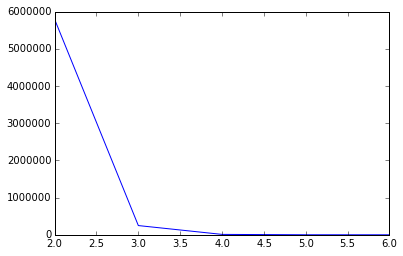

In [20]:
plt.plot([2,3,4,5,6],[avg_cp(x) for x in [2,3,4,5,6]])

In [ ]:
def dict_to_list(dict, min=2):
    res = []
    for key in dict.keys():
        if key > min:
            res.extend(dict[key])
    return res

def find_matches(word, word_list):
    res = find_letter_recurse(word.lower(), 1, word_list)
    #for idx in res:
    #    print idx, word_list[idx]
    matches = {}
    i = 0
    while len(res) > 0:
        i += 1
        matches[i] = word_list[res[0]:res[1]+1]
        if len(res) > 2:
            matches[i].extend(word_list[res[-2]:res[-1]+1])
        res = res[1:-1]
    return matches

def find_letter_recurse(word, idx, word_list):
    if idx > len(word):
        return []
    
    substr = word[:idx]
    lower = bisect_right(word_list, substr) - 1
    
    low_word = word_list[lower]
    #print "low_word", low_word
    
    #couldn't find any exact matches
    if len(low_word) < idx or low_word[:idx] != word[:idx]:
        lower += 1
        low_word = word_list[lower]
        #print "new low word", low_word
        if len(low_word) < idx or low_word[:idx] != word[:idx]:
            return []

    last_letter = substr[-1]
    
    if last_letter is 'z':
        upper = len(word_list) - 1
    else:
        substr_end = substr[:-1] + chr(ord(last_letter) + 1)
        upper = bisect_left(word_list, substr_end) - 1
        upper_word = word_list[upper]
        #print "upper word", upper_word
        if len(upper_word) < idx or upper_word[:idx] != word[:idx]:
            upper -= 1
            upper_word = word_list[upper]
            #print "new upper word", upper_word
            if len(upper_word) < idx or upper_word[:idx] != word[:idx]:
                return []
         
    
    cut_list = word_list[lower:upper+1]
    
    res = find_letter_recurse(word, idx + 1, cut_list)
    res = [idx + lower for idx in res]
    res.insert(0, lower)
    res.append(upper)
    
    return res


In [63]:
heyoo = create_lists("hello")[1]

In [96]:
def get_length_match(blend, candidate):
    for i in range(len(blend) + 1):
        if blend[:i] != candidate[:i]:
            return i
    return len(blend)

def get_length_matches(blend, candidates, front=True):
    if not front:
        blend = blend[::-1]
        candidates = [candidate[::-1] for candidate in candidates]
    
    with_lengths = [(get_length_match(blend, candidate), candidate) for candidate in candidates]
    if not front:
        #fix wackiness
        with_lenghts = [(length, candidate[::-1]) for length, candidate in with_lengths]
    return with_lengths


In [108]:
from itertools import groupby

def find_match_count(starters, enders, blend, exact=False):
    start_lengths = [length for length, candidate in get_length_matches(blend, starters, front=True)]
    end_lengths = [length for length, candidate in get_length_matches(blend, starters, front=False)]
    
    start_lengths.sort()
    end_lengths.sort()
    
    l1 = [len(list(group)) for key, group in groupby(start_lengths)]
    l2 = [len(list(group)) for key, group in groupby(end_lengths)]
    
    return match_amounts(l1, l2)

In [91]:
def match_amounts(l1, l2):
    l2.reverse()
    count = 0
    for a1, a2 in zip(l1, l2):
        count += a1 * a2
    return count   

In [114]:
def total_count(blend, min=2):
    lists = create_lists(blend,min=min)
    return find_match_count(lists[0], lists[1], blend)

In [105]:
lengths = [total_count(blend) for blend in blends]

In [115]:
def avg_prods(min, blends=blends):
    lengths = [total_count(blend, min=min) for blend in blends]
    avg = sum(lengths) / len(lengths)
    return avg

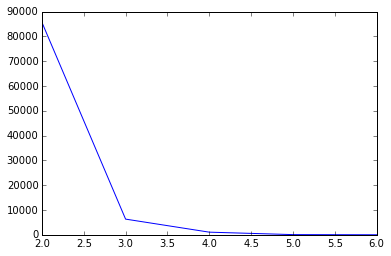

In [116]:
plt.plot([2,3,4,5,6],[avg_prods(x) for x in [2,3,4,5,6]])

In [117]:
x_axis = [2,3,4,5,6]
small_prods_line = [avg_prods(x) for x in x_axis]
big_prods_line = [avg_cp(x) for x in x_axis]

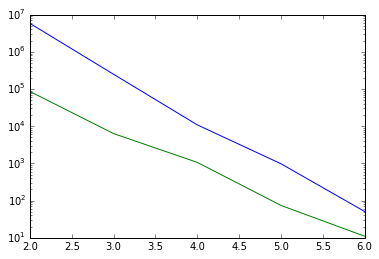

In [120]:
plt.yscale("log")
plt.plot(x_axis, big_prods_line, x_axis, small_prods_line)

In [125]:
"whacker" in blends

False